In [1]:
import qcomplexity as qc
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
import numpy as np

np.set_printoptions(linewidth=100000)

In [3]:
# Plots the geodesic curve along the unitary manifold, starting at some initial set of parameters and pointing in the direction of a
# tangent vector

inertia = jnp.array([
    [1.0, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.1]
])

metric = jax.jit(qc.numerical_metric(inertia, qc.ham_fn)) # Metric tensor
christoffel_symbols = jax.jit(qc.numerical_christoffel_symbols(metric)) # Christoffel symbols

In [5]:
# The right-hand side of the geodesic differential equation
diff_fn = lambda *args : jnp.real(qc.diff_fn(christoffel_symbols)(*args))

In [6]:
# We can now solve the boundary value problem yielded form the geodesic equations

def batch_diff_fn(y1, y2):
    """Returns a batch of diff_fn evaluations"""
    return np.array([diff_fn(a, b) for a, b in zip(y1.T, y2.T)]).T

def prepare_guess(init, fin, steps):
    """Prepares initial guess for a given set of initial + final params"""
    first_rows = np.linspace(init, fin, steps).T
    second_rows = np.tile(fin - init, (steps, 1)).T
    return np.vstack([first_rows, second_rows])

In [48]:
nodes = 10 # Number of nodes for BVP solver to use
init = jnp.array([0.0, 0.0, 0.0], dtype=complex)
fin = jnp.array([0.3, 0.6, 0.0], dtype=complex) # Boundary condition
x = np.linspace(0, 1, nodes)

x_guess = prepare_guess(init, fin, nodes) # Initial solution guess
x_guess = y_plot

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3584: UserWarning: Explicitly requested dtype <class 'complex'> requested in array is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


In [49]:
# Boundary conditions penalty
def bc(ya, yb):
    return np.array([ya[0:3] - init, yb[0:3] - fin]).flatten()

# BVP function
def f(x, y):
    s = y.shape[1]
    y = y.reshape(2, 3, s)
    #print(np.real(batch_diff_fn(y[0], y[1])))
    v = np.vstack((
        y[1], 
        -batch_diff_fn(y[0], y[1])
    )).reshape(6, s)
    #print(v)
    return v

def new_f(x, y):
    y = y.reshape(2, 3)
    v = np.vstack((
        y[1], 
        -diff_fn(y[0], y[1])
    )).reshape(6)
    return v

In [50]:
res = solve_bvp(f, bc, x, x_guess, verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.22e-03       2.03e-03          10              8       
       2          1.39e-04       3.43e-05          18              0       
Solved in 2 iterations, number of nodes 18. 
Maximum relative residual: 1.39e-04 
Maximum boundary residual: 3.43e-05


In [51]:
x_guess.shape

(6, 10)

In [52]:
print(y_plot.shape)

(6, 10)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


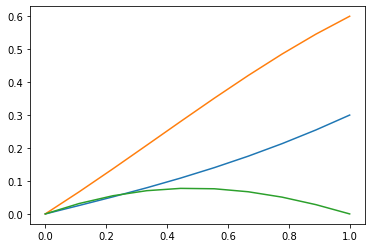

In [53]:
x_plot = np.linspace(0, 1, 10)
y_plot = res.sol(x_plot)

plt.plot(x_plot, y_plot[0])
plt.plot(x_plot, y_plot[1])
plt.plot(x_plot, y_plot[2])

In [18]:
jit_diff = jax.jit(diff_fn)

In [19]:
def body_fn(i, val):
    x, v = val[0], val[1]
    a = -jit_diff(x, v)
    x = x + v * (1/100) + (0.5 * (1/100) ** 2) * a
    v = v + a * (1/100)
    return jnp.array([x, v])

In [560]:
def solve_ivp(v_init):
    """Solves for the endpoint of an IVP"""
    x = jnp.array([0.0, 0.0, 0.0], dtype=complex)
    v = v_init
    for s in np.linspace(0, 1, 100):
        a = -jit_diff(x, v)
        x = x + v * (1/100) + (0.5 * (1/100) ** 2) * a
        v = v + a * (1/100)
    return x

def jax_solve(v):
    return jax.lax.fori_loop(0, 100, body_fn, jnp.vstack((jnp.array([0.0, 0.0, 0.0], dtype=complex), v)))

def cost_fn(v):
    """Cost function"""
    return float(np.linalg.norm(solve_ivp(v) - fin))

In [561]:
from scipy.optimize import minimize

In [566]:
v = jnp.array([0.3, 0.5, 0.2], dtype=complex)
minimize(cost_fn, v, method="COBYLA")

     fun: 0.00018354706116952002
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 96
  status: 1
 success: True
       x: array([0.68942411, 0.99115498, 1.31267012])

In [567]:
solve_ivp(jnp.array([0.68942411, 0.99115498, 1.31267012], dtype=complex))

DeviceArray([ 1.1301407e+00+0.j,  6.0002702e-01+0.j, -1.1477491e-04+0.j], dtype=complex64)

In [441]:
# Attempt to propogate along the manifold
x = jnp.array([0.0, 0.0, 0.0], dtype=complex)
v = jnp.array([0.3, 0.5, 0.2], dtype=complex)

l = []

for s in jnp.linspace(0, 1, 100):
    a = -diff_fn(x, v)
    x = x + v * (1/100) + (0.5 * (1/100) ** 2) * a
    v = v + a * (1/100)
    l.append(x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


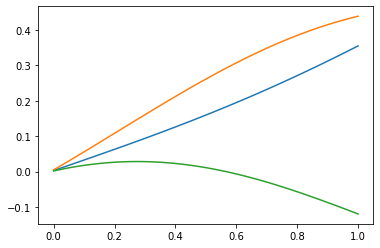

In [442]:
plt.plot(np.linspace(0, 1, 100), l)

In [437]:
res = solve_ivp(new_f, [0, 1], jnp.array([0.0, 0.0, 0.0, 0.3, 0.5, 0.2], dtype=complex), dense_output=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3584: UserWarning: Explicitly requested dtype <class 'complex'> requested in array is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


ValueError: x and y must have same first dimension, but have shapes (100,) and (8,)

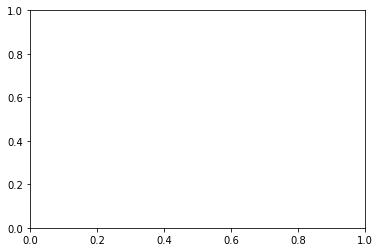

In [426]:
plt.plot(x_plot, y_plot[3])
plt.plot(x_plot, y_plot[4])
plt.plot(x_plot, y_plot[5])